In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [17]:
sample = pd.read_csv('data/part3data.txt', names=['Exam1', 'Exam2', 'Pass'])
sample.head()

,Exam1,Exam2,Pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


# Visualization

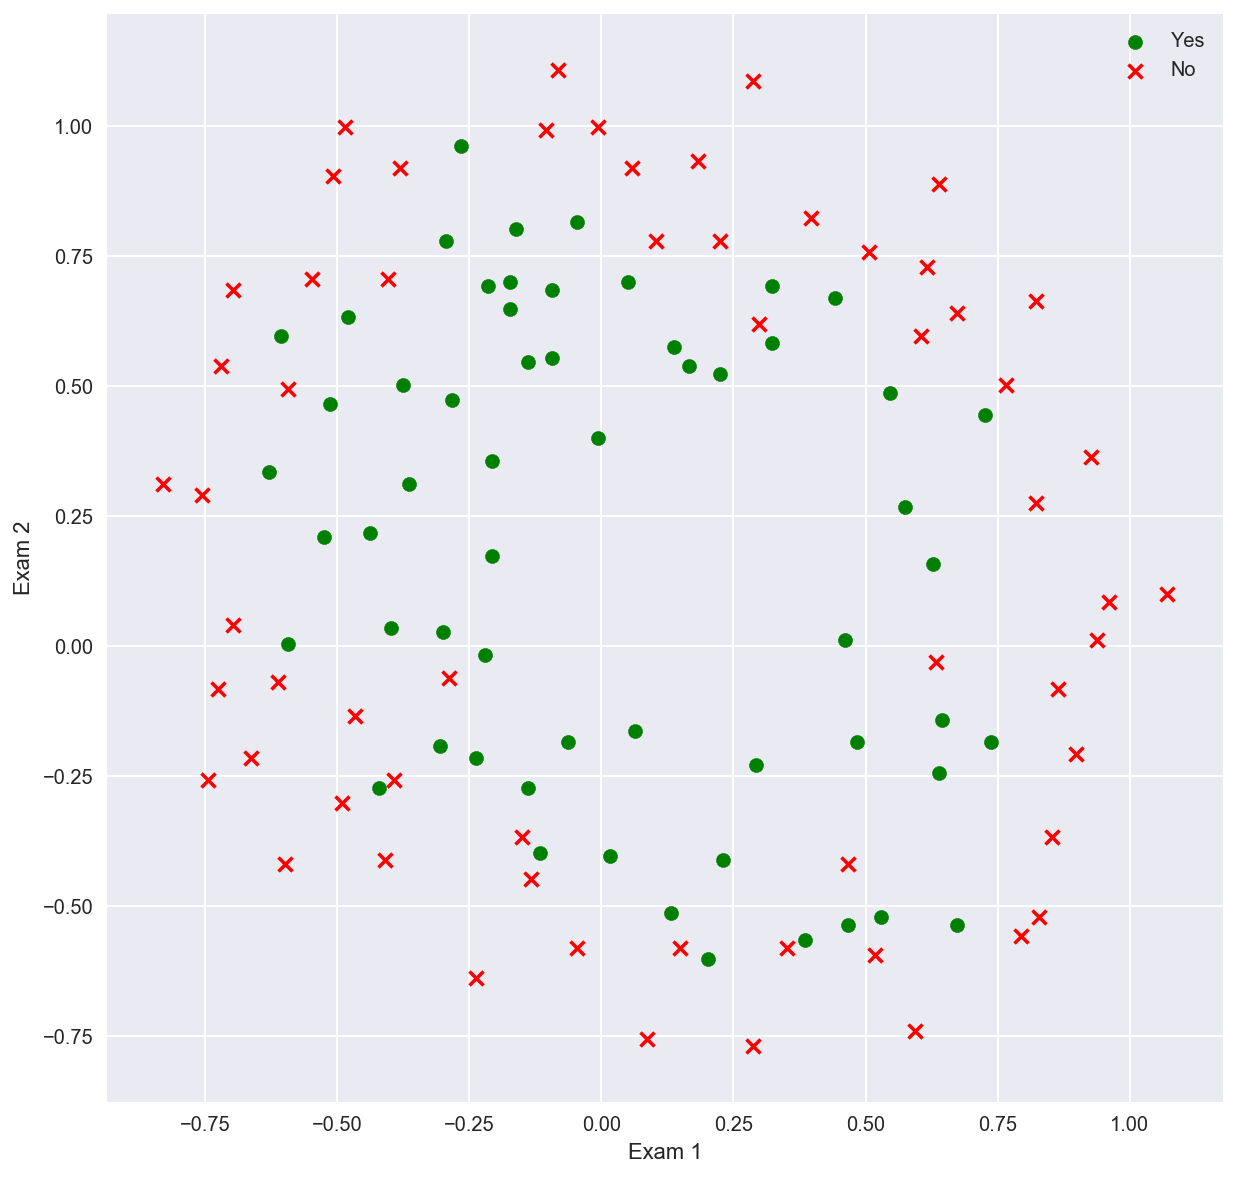

In [18]:
a = sample[ sample['Pass'] == 1 ]
b = sample[ sample['Pass'] == 0 ]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(a.ix[:, 0], a.ix[:, 1], marker='o', c='g')
ax.scatter(b.ix[:, 0], b.ix[:, 1], marker='x', c='r')
ax.set_xlabel('Exam 1')
ax.set_ylabel('Exam 2')
ax.legend(('Yes', 'No'))

# Logistic Regression

### sigmoid function
$f(x)=\frac{1}{1+e^{-x}}$

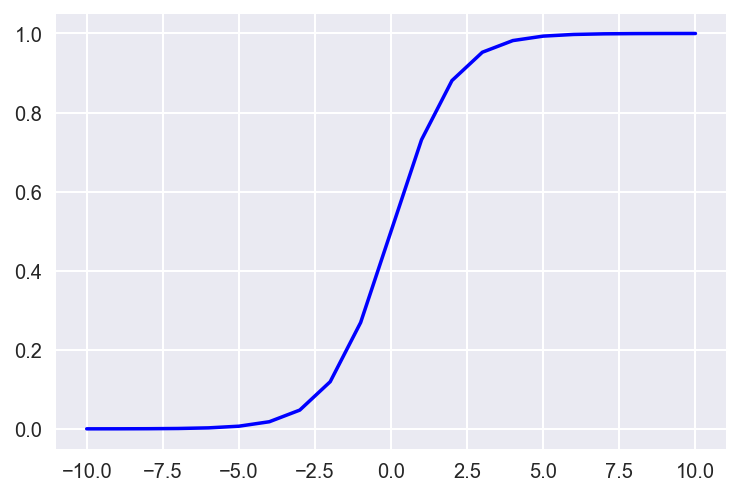

In [19]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

tempX = np.array(range(-10,11))
tempY = list( map(sigmoid, tempX) )
plt.plot(tempX, tempY, 'b')

### Feature Mapping

In [20]:
def mapFeature(x1, x2, degree):
    tmp = pd.DataFrame()
    tmp['one'] = np.ones(len(x1))
#     tmp['X1'] = x1
#     tmp['X2'] = x2
    
    for i in range(1, degree):  
        for j in range(0, i):
            tmp['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
   
    return tmp

degree = 5
passData = sample['Pass']
newDataSet = mapFeature(sample['Exam1'], sample['Exam2'], degree)
newDataSet['Pass'] = passData

x = newDataSet.ix[:, :-1]
y = newDataSet.ix[:, -1:]

newDataSet.head()

,one,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43,Pass
0,1.0,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551,1
1,1.0,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801,1
2,1.0,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895,1
3,1.0,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494,1
4,1.0,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818,1


### Cost function
$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m \large[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\large] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

In [21]:
def cost(theta, x, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(x)
    y = np.matrix(y)
    left = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    right = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = ( learningRate / (2 * len(X)) ) * np.sum( np.power(theta[:,1:theta.shape[1]], 2) )
    return np.sum(left - right) / (len(X)) + reg

### Gradient function

In [22]:
def gradient(theta, X, y, learningRate):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])

    return grad

### Minimize cost function using 'scipy' and 'BFGS' algorithm

In [23]:
x0 = np.zeros( (x.shape[1],1) )
landa = .0001
res = opt.minimize(cost, x0,jac=gradient, method='BFGS', args=(x, y, landa), options={'disp': True})
print( res.x )

# res.x = np.array([ 0.35872309, -3.22200653, 18.97106363, -4.25297831, 18.23053189, 20.36386672, 8.94114455, -43.77439015, -17.93440473, -50.75071857, -2.84162964])
# print( res.x )

Optimization terminated successfully.
         Current function value: 0.436872
         Iterations: 133
         Function evaluations: 135
         Gradient evaluations: 135
[  0.37480412  -2.97787099  18.13879383  -4.50609427  17.22807478
  19.26328563   8.17566135 -41.89382998 -16.23264638 -48.59426306
  -2.05708827]


### ترسیم مرز تصمیم - امتیازی

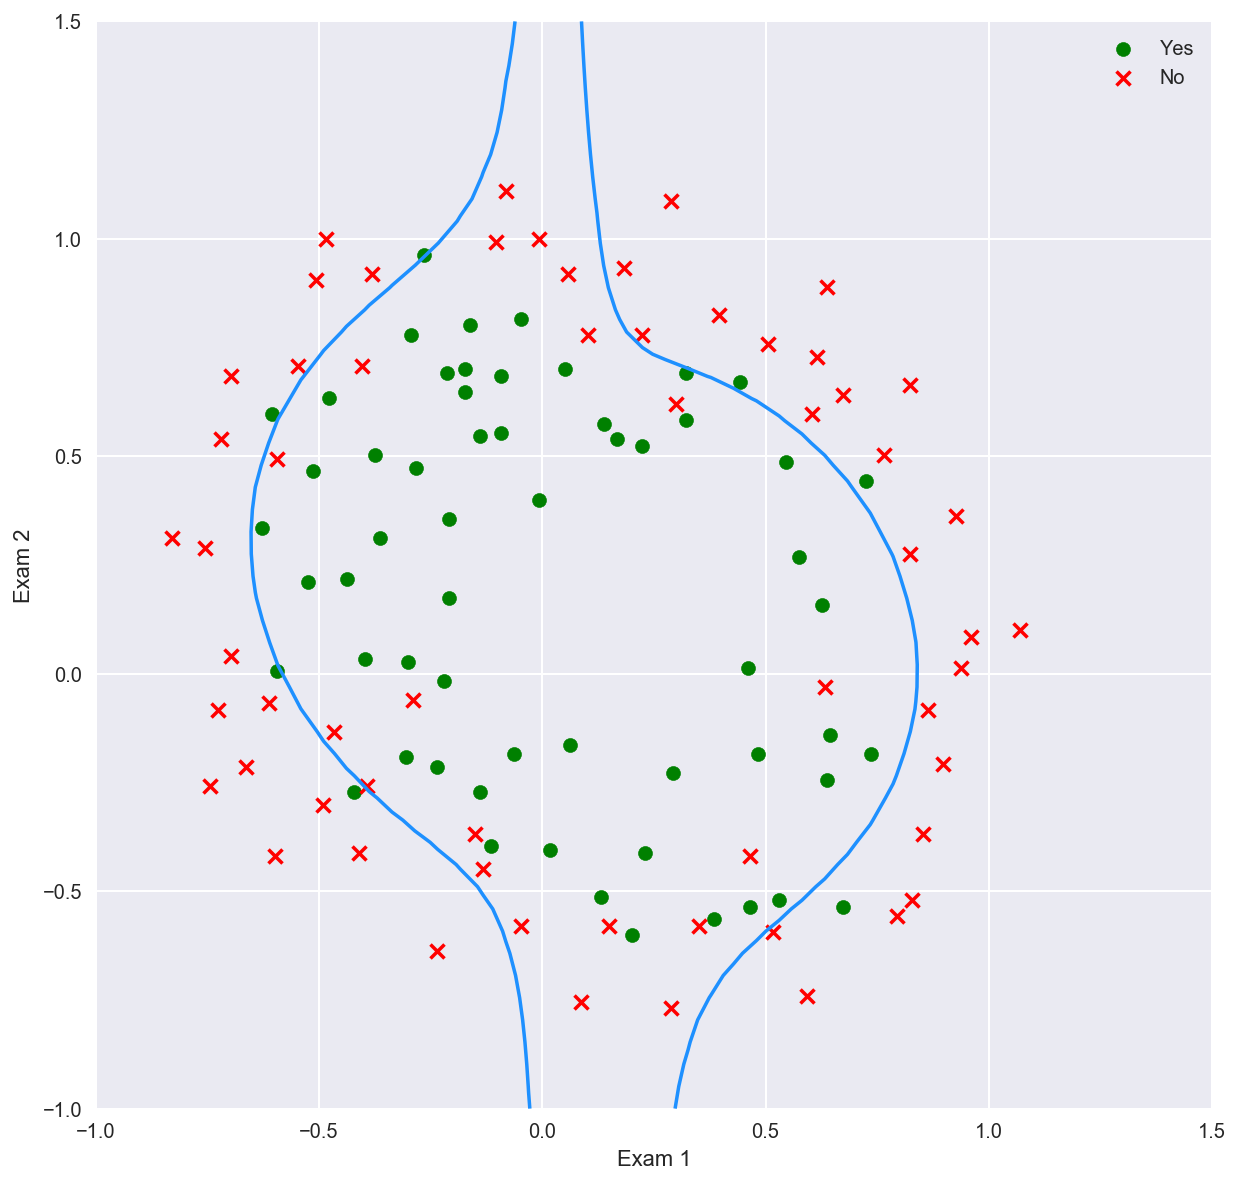

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(a.ix[:, 0], a.ix[:, 1], marker='o', c='g')
ax.scatter(b.ix[:, 0], b.ix[:, 1], marker='x', c='r')
ax.set_xlabel('Exam 1')
ax.set_ylabel('Exam 2')
ax.legend(('Yes', 'No'))

def plot_decision_boundary(ax, theta, X, y, degree):
    z = np.zeros([50, 50])
    uu = np.linspace(-1.0, 1.5, 50)
    vv = np.linspace(-1.0, 1.5, 50)
    
    for i, u in enumerate(uu):
        for j, v in enumerate(vv):
            z[i, j] = np.dot(mapFeature(np.array([[u]]), np.array([[v]]), degree), theta)[0]
            
    ax.contour(uu, vv, z.T, [0], colors='dodgerblue')

plot_decision_boundary(ax, res.x, x, y, degree)